In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
import numpy as np

# for reproducibility
torch.manual_seed(42)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

# for reproducibility
torch.manual_seed(42)

In [3]:
# Set base data directory
data_dir = "/kaggle/input/drowsy"

# Define parameters
IMG_SIZE = 224
BATCH_SIZE = 32
TRAIN_RATIO = 0.7  # 70% for training
VAL_RATIO = 0.15   # 15% for validation
TEST_RATIO = 0.15  # 15% for testing

In [4]:
# Define the transformations
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),   # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
import glob
from sklearn.model_selection import train_test_split

# Use glob to recursively find all png files
all_image_paths = glob.glob(os.path.join(data_dir, "**", "*.png"), recursive=True)

# --- NEW ---
# We must create a list of labels *before* splitting
# 0 = Drowsy ('A'...), 1 = Non Drowsy ('a'...)
all_labels = []
for img_path in all_image_paths:
    filename = os.path.basename(img_path)
    if filename.startswith('a'):
        all_labels.append(1)  # Non Drowsy
    else:
        all_labels.append(0)  # Drowsy
        
print(f"Found {len(all_image_paths)} total images.")
print(f"Found {len(all_labels)} total labels.")

# Check the balance
drowsy_count = all_labels.count(0)
non_drowsy_count = all_labels.count(1)
print(f"Data balance: {drowsy_count} Drowsy (0) | {non_drowsy_count} Non Drowsy (1)")

Found 41793 total images.
Found 41793 total labels.
Data balance: 40541 Drowsy (0) | 1252 Non Drowsy (1)


In [6]:
class CustomDrowsyDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        # We define our class names based on your logic:
        # Drowsy (A00...) = 0, Non Drowsy (a00...) = 1
        self.class_names = ['Drowsy', 'Non Drowsy']

    def __len__(self):
        # Returns the total number of samples
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1. Get the path for one image
        img_path = self.image_paths[idx]
        
        # 2. Load that single image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # You might want to return a blank image or skip
            return None, None # Handle this in the dataloader if needed

        # 3. Determine the label based on the filename
        # We get just the filename, e.g., "A0001.png" or "a0002.png"
        filename = os.path.basename(img_path)
        
        # Based on your logic: "if contain A00 its drowsy else if a00 is non drowsy"
        # We interpret this as:
        # 'A' (like in A0001.png) -> Drowsy -> Label 0
        # 'a' (like in a0002.png) -> Non Drowsy -> Label 1
        
        if filename.startswith('a'):
            label = 1  # Non Drowsy
        else:
            # Assume anything else (like 'A') is Drowsy
            label = 0  # Drowsy
            
        # 4. Apply transforms
        if self.transform:
            image = self.transform(image)
            
        return image, label

# We'll need this for the visualization cell later
class_names = ['Drowsy', 'Non Drowsy']

In [11]:
# 1. First split: separate out a training set (70%)
# The remaining 30% will be in temp_paths
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths,
    all_labels,
    test_size=(1.0 - TRAIN_RATIO), # 30% for temp
    random_state=42,
    stratify=all_labels  # This is the magic!
)

# 2. Second split: split the 30% temp set into val (15%) and test (15%)
# (0.15 / 0.30) = 0.5, so we split the temp set 50/50
relative_test_size = TEST_RATIO / (VAL_RATIO + TEST_RATIO)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=relative_test_size, # 50% of the temp set
    random_state=42,
    stratify=temp_labels # Also stratify this split
)

print(f"Training set:   {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Test set:       {len(test_paths)} images")

# You can add this to verify stratification
print(f"\nTraining set balance: {train_labels.count(0)} Drowsy | {train_labels.count(1)} Non Drowsy")
print(f"Validation set balance: {val_labels.count(0)} Drowsy | {val_labels.count(1)} Non Drowsy")

Training set:   29255 images
Validation set: 6269 images
Test set:       6269 images

Training set balance: 28379 Drowsy | 876 Non Drowsy
Validation set balance: 6081 Drowsy | 188 Non Drowsy


In [12]:
# Re-use the CustomDrowsyDataset class from the previous notebook
# (Make sure the cell that defines it has been run)

# Create three separate dataset objects
train_dataset = CustomDrowsyDataset(image_paths=train_paths, transform=data_transform)
val_dataset = CustomDrowsyDataset(image_paths=val_paths, transform=data_transform)
test_dataset = CustomDrowsyDataset(image_paths=test_paths, transform=data_transform)

# Set the class_names variable (used in the visualization cell)
class_names = train_dataset.class_names

print("Three separate Dataset objects created.")

Three separate Dataset objects created.


In [13]:
# Create DataLoaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle training data
    num_workers=2
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print("\nDataLoaders created successfully.")


DataLoaders created successfully.


In [14]:
print("\nDataLoaders created successfully.")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")


DataLoaders created successfully.
Number of batches in train_loader: 915
Number of batches in val_loader: 196
Number of batches in test_loader: 196


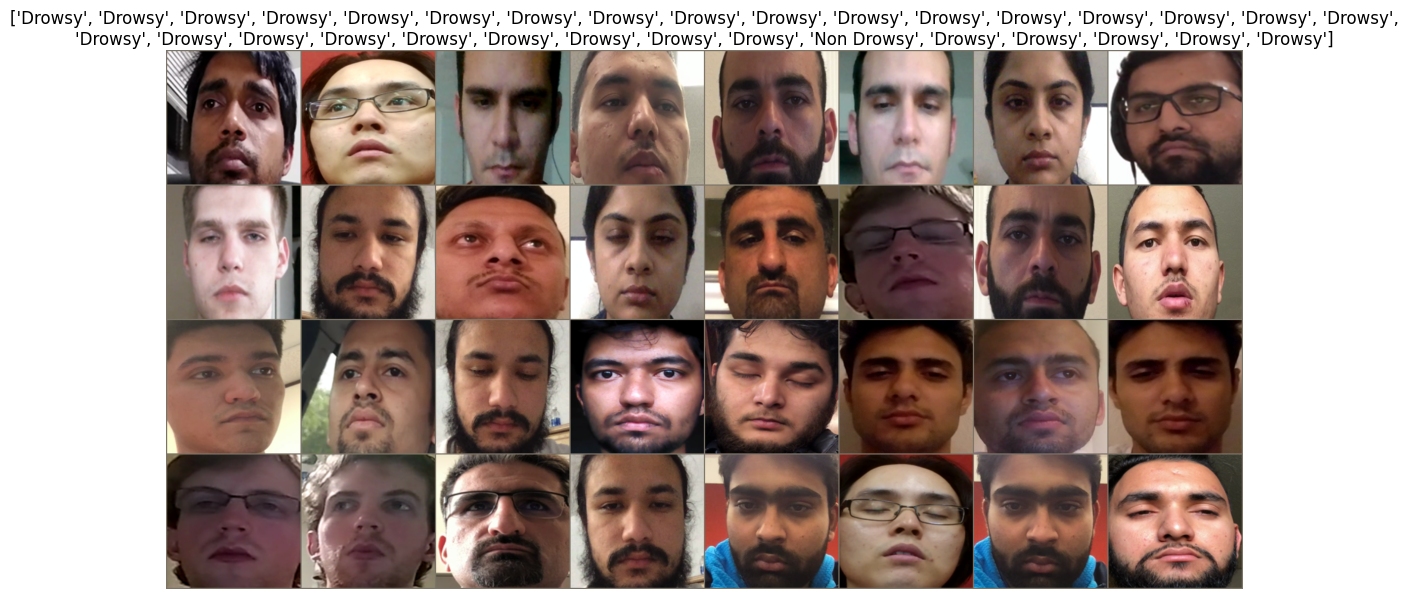

In [15]:
# Helper function to un-normalize and display an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, wrap=True)
    plt.axis('off')

# Get one batch of training images
try:
    inputs, classes = next(iter(train_loader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs, nrow=8)

    # Get the corresponding labels
    labels = [class_names[x] for x in classes]

    # Display the images
    plt.figure(figsize=(15, 7))
    imshow(out, title=str(labels))
    plt.show()

except Exception as e:
    print(f"Error visualizing data: {e}")

In [17]:
import torchvision.models as models
import torch.nn as nn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load a pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# 2. Freeze all parameters in the model
print("Freezing all model layers...")
for param in model.parameters():
    param.requires_grad = False
    
# 3. Replace the final layer (the "classifier")
# ResNet-18's final layer is named 'fc'
# We get the number of input features to that layer
num_ftrs = model.fc.in_features

# We replace it with a new Linear layer.
# We set out_features=1, as we only need one output for binary classification.
# (We will use BCEWithLogitsLoss, which expects a single raw output)
model.fc = nn.Linear(num_ftrs, 1)

# 4. Move the model to the GPU (if available)
model = model.to(device)

print("\nModel definition complete. Only the final 'fc' layer is trainable.")
# print(model) # Uncomment this to see the full model structure

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s] 


Freezing all model layers...

Model definition complete. Only the final 'fc' layer is trainable.


In [18]:
import torch.optim as optim

# Define the Loss Function
# BCEWithLogitsLoss is perfect for binary (0/1) classification
# with a single output neuron. It's numerically stable.
criterion = nn.BCEWithLogitsLoss()

# Define the Optimizer
# We tell Adam to ONLY optimize the parameters of the final layer ('model.fc').
# All other layers are frozen and will not be updated.
optimizer = optim.Adam(
    model.fc.parameters(),  # <-- Notice we only pass the 'fc' parameters
    lr=0.001                # A good starting learning rate
)

print("Loss function and optimizer are ready.")

Loss function and optimizer are ready.


In [19]:
from tqdm import tqdm

# Define number of epochs to train for
NUM_EPOCHS = 10 # You can start with 10-15 for fine-tuning

print("Starting training...")

for epoch in range(NUM_EPOCHS):
    
    # --- Training Phase ---
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    
    # Use tqdm for a progress bar
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for inputs, labels in train_bar:
        # Move data to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # We need to convert labels to float and reshape
        # from [batch_size] to [batch_size, 1] to match the model's output
        labels = labels.float().unsqueeze(1)
        
        # 1. Zero the gradients
        optimizer.zero_grad()
        
        # 2. Forward pass
        outputs = model(inputs)
        
        # 3. Calculate the loss
        loss = criterion(outputs, labels)
        
        # 4. Backward pass
        loss.backward()
        
        # 5. Optimize
        optimizer.step()
        
        # Update running loss
        running_train_loss += loss.item() * inputs.size(0)
        
        # Update progress bar
        train_bar.set_postfix(loss=loss.item())
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_dataset)

    # --- Validation Phase ---
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_preds = 0
    total_samples = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
    with torch.no_grad():  # No gradients needed for validation
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1) # Match shape
            
            # Forward pass
            val_outputs = model(inputs)
            
            # Calculate loss
            val_loss = criterion(val_outputs, labels)
            running_val_loss += val_loss.item() * inputs.size(0)
            
            # Calculate predictions
            # The model outputs raw logits. For binary classification,
            # anything > 0 is predicted as class 1, else class 0.
            preds = (val_outputs > 0).float()
            
            # Update correct predictions and total samples
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)
            
    # Calculate average validation loss and accuracy
    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_acc = (correct_preds / total_samples) * 100
    
    # Print statistics for the epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_val_acc:.2f}%")

print("Finished Training.")

Starting training...


Epoch 1/10 [Val]: 100%|██████████| 196/196 [00:36<00:00,  5.38it/s]


Epoch 1/10 | Train Loss: 0.0206 | Val Loss: 0.0013 | Val Acc: 100.00%


Epoch 2/10 [Val]: 100%|██████████| 196/196 [00:21<00:00,  9.19it/s]


Epoch 2/10 | Train Loss: 0.0011 | Val Loss: 0.0004 | Val Acc: 100.00%


Epoch 3/10 [Val]: 100%|██████████| 196/196 [00:20<00:00,  9.49it/s]


Epoch 3/10 | Train Loss: 0.0005 | Val Loss: 0.0002 | Val Acc: 100.00%


Epoch 4/10 [Val]: 100%|██████████| 196/196 [00:20<00:00,  9.36it/s]


Epoch 4/10 | Train Loss: 0.0003 | Val Loss: 0.0001 | Val Acc: 100.00%


Epoch 5/10 [Val]: 100%|██████████| 196/196 [00:20<00:00,  9.55it/s]


Epoch 5/10 | Train Loss: 0.0001 | Val Loss: 0.0000 | Val Acc: 100.00%


Epoch 6/10 [Val]: 100%|██████████| 196/196 [00:20<00:00,  9.66it/s]


Epoch 6/10 | Train Loss: 0.0001 | Val Loss: 0.0000 | Val Acc: 100.00%


Epoch 7/10 [Val]: 100%|██████████| 196/196 [00:19<00:00, 10.03it/s]


Epoch 7/10 | Train Loss: 0.0001 | Val Loss: 0.0000 | Val Acc: 100.00%


Epoch 8/10 [Val]: 100%|██████████| 196/196 [00:19<00:00, 10.00it/s]


Epoch 8/10 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


Epoch 9/10 [Val]: 100%|██████████| 196/196 [00:19<00:00,  9.82it/s]


Epoch 9/10 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


Epoch 10/10 [Val]: 100%|██████████| 196/196 [00:19<00:00,  9.92it/s]

Epoch 10/10 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
Finished Training.


Evaluating model on the test set...


Testing: 100%|██████████| 196/196 [00:33<00:00,  5.81it/s]



--- Classification Report ---
              precision    recall  f1-score   support

      Drowsy       1.00      1.00      1.00      6081
  Non Drowsy       1.00      1.00      1.00       188

    accuracy                           1.00      6269
   macro avg       1.00      1.00      1.00      6269
weighted avg       1.00      1.00      1.00      6269


--- Confusion Matrix ---


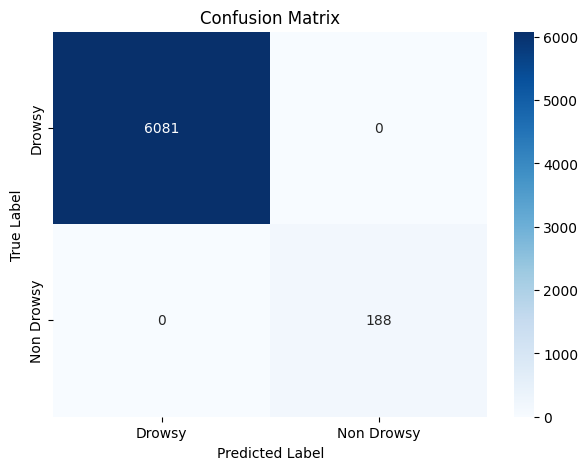

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# We need to collect all predictions and true labels from the test set
all_labels = []
all_preds = []

print("Evaluating model on the test set...")
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get model outputs (logits)
        outputs = model(inputs)
        
        # Convert logits to predictions (0 or 1)
        preds = (outputs > 0).float()
        
        # Move predictions and labels to CPU and store them
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Classification Report ---
# Remember: 0 = Drowsy, 1 = Non Drowsy
target_names = class_names  # ['Drowsy', 'Non Drowsy'] from Cell 6

print("\n--- Classification Report ---")
# We need to squeeze the preds list in case it's [N, 1] instead of [N]
report = classification_report(all_labels, 
                             np.array(all_preds).squeeze(), 
                             target_names=target_names)
print(report)


# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, np.array(all_preds).squeeze())
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

plt.figure(figsize=(7, 5))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()